# Data Exploration: Munich Bicycle Counting Stations

There are 6 bicycle counting stations in munich and all of them also record meteorological data.


## Load the data

In [2]:
import pandas as pd

# Read the counting data from the json file, set the datum as index, but also keep the datum column
counting_data_file = "../datasources/munich-bicycle-counting-stations/cleaned/bicycle-counting-station-daily.json"
df = pd.read_json(counting_data_file, lines=True)
df['datum'] = pd.to_datetime(df['datum'], unit='ms')
df['datum_index'] = df['datum']
df.set_index('datum_index', inplace=True)

# Data should be sorted in the file, but just to be sure
df.sort_values(by='datum', inplace=True)

# Calculate the average temperature
df['avg-temp'] = (df['min-temp'] + df['max-temp']) / 2

# Create a complete date range from min to max date in your data
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Find missing dates
missing_dates = complete_date_range.difference(df.index)

assert len(missing_dates) == 0
print("There are no missing dates, continuing")

There are no missing dates, continuing


In [3]:
# We want to find the sum of all bikes that passed the counting stations on a given day
# so we group by the date and sum the values.
# The environmental values are the same for all stations, so we can just take the first value

aggregation_functions = {'datum': 'first',
                         'min-temp': 'first',
                         'max-temp': 'first',
                         'avg-temp': 'first',
                         'niederschlag': 'first',
                         'bewoelkung': 'first',
                         'sonnenstunden': 'first',
                         'gesamt': 'sum'}

aggregated_df = df.groupby(df['datum']).aggregate(aggregation_functions)
# Assuming 'datum' column is in datetime format
aggregated_df['monat'] = aggregated_df['datum'].dt.month

aggregated_df.head(20)

,datum,min-temp,max-temp,avg-temp,niederschlag,bewoelkung,sonnenstunden,gesamt,monat
datum,,,,,,,,,
2008-06-01,2008-06-01,12.5,26.7,19.60,0.0,30,13.9,667,6
2008-06-02,2008-06-02,15.0,27.9,21.45,0.6,44,12.1,1117,6
2008-06-03,2008-06-03,14.6,21.9,18.25,0.2,88,3.2,1279,6
2008-06-04,2008-06-04,14.8,21.9,18.35,5.1,91,1.4,758,6
2008-06-05,2008-06-05,14.0,20.4,17.20,14.2,91,0.6,606,6
2008-06-06,2008-06-06,13.6,19.9,16.75,10.0,81,1.7,963,6
2008-06-07,2008-06-07,13.6,18.2,15.90,2.0,95,0.7,399,6
2008-06-08,2008-06-08,12.6,22.0,17.30,3.9,83,5.4,557,6
2008-06-09,2008-06-09,9.5,23.0,16.25,0.0,63,11.5,1244,6


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculating the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculating the Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features and target variables

# If we had live data from the stations we could improve the models by adding look-back features, but as
# we only get the environmental data, we can only use the current day's data
# features = ['monat', 'avg_last_week', 'vortag_gesamt', 'min-temp', 'max-temp', 'avg-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden']

# We reduce the features to the ones that are most likely to have an impact on the number of bikes and
# which we can easily get from the weather API
features = ['monat', 'min-temp', 'max-temp', 'avg-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden']
# features = ['avg-temp']
target = 'gesamt'

# Splitting the data into training and testing sets based on the date
train_data = aggregated_df[aggregated_df['datum'] < '2022-01-01']
test_data = aggregated_df[aggregated_df['datum'] >= '2022-01-01']

# Splitting the features and target for training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


In [6]:
X_train.shape

(4962, 7)

In [23]:
import pickle
import joblib
import time
import sys

# Creating and fitting the linear regression model
model = LinearRegression()
start = time.time()
model.fit(X_train, y_train)
end = time.time()
delta = end - start
size_sys = sys.getsizeof(pickle.dumps(model))

# Predicting on the test set
start_predict = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()
delta_predict = end_predict - start_predict
y_pred = y_pred * 1.4

# Calculating and printing the MAPE and WAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
wape = weighted_absolute_percentage_error(y_test, y_pred)
print("Time to train:", delta)
print("Time to predict:", delta_predict)
print("Model size:", size_sys)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Absolute Percentage Error (WAPE):", wape)


Time to train: 0.005738973617553711
Time to predict: 0.0018298625946044922
Model size: 720
Mean Absolute Percentage Error (MAPE): 34.389187154958094
Weighted Absolute Percentage Error (WAPE): 26.71851017343497


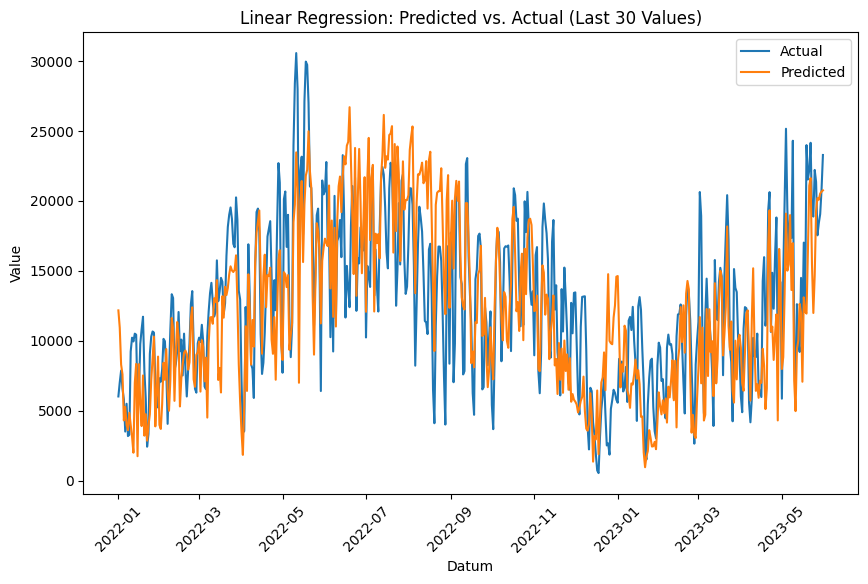

In [20]:
# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('Linear Regression: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Creating and fitting the Random Forest model
model = RandomForestRegressor(n_estimators=200, n_jobs=6)
start = time.time()
model.fit(X_train, y_train)
end = time.time()
delta = end - start
size_sys = sys.getsizeof(pickle.dumps(model))
# Predicting on the test set
start_predict = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()
delta_predict = end_predict - start_predict

factor = 1.4
y_pred = y_pred * factor

# Evaluating the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Calculating and printing the MAPE and WAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
wape = weighted_absolute_percentage_error(y_test, y_pred)
print("Time to train:", delta)
print("Time to predict:", delta_predict)
print("Model size:", size_sys)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Absolute Percentage Error (WAPE):", wape)

Mean Squared Error: 20511742.503750768
Time to train: 2.0255706310272217
Time to predict: 0.0385744571685791
Model size: 80284153
Mean Absolute Percentage Error (MAPE): 36.3133858498532
Weighted Absolute Percentage Error (WAPE): 29.122951529387304


In [ ]:
# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[-90:], y_test[-90:], label='Actual')
plt.plot(y_test.index[-90:], y_pred[-90:], label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('RandomForestRegressor: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
start = time.time()
# Fit the model
model_fit = model.fit(disp=False)
end = time.time()
delta = end - start
size_sys = sys.getsizeof(pickle.dumps(model))


/home/jonas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jonas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jonas/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time to train: 2.0255706310272217
Model size: 80284153
Time to predict: 0.07270622253417969
Mean Absolute Percentage Error (MAPE): 38.37631361985351
Weighted Absolute Percentage Error (WAPE): 24.05447798150755


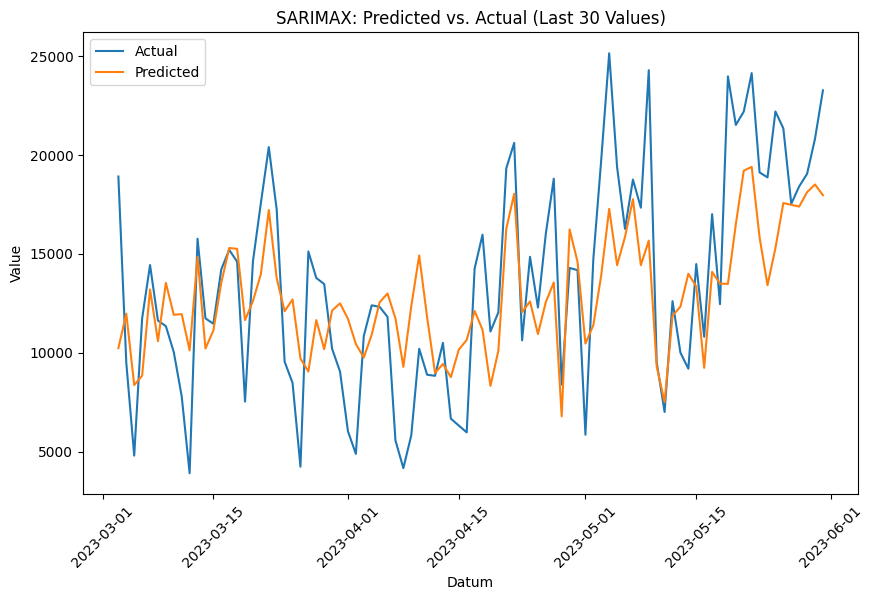

In [26]:
# Predict on the test set
start = X_test.index[0]
end = X_test.index[-1]
start_predict = time.time()
y_pred = model_fit.predict(start=start, end=end, exog=X_test)
end_predict = time.time()
delta_predict = end_predict - start_predict
y_pred = y_pred * 0.95
# Calculating and printing the MAPE and WAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
wape = weighted_absolute_percentage_error(y_test, y_pred)
print("Time to train:", delta)
print("Time to predict:", delta_predict)
print("Model size:", size_sys)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Absolute Percentage Error (WAPE):", wape)
# Plotting predicted vs. actual values with 'datum' as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[-90:], y_test[-90:], label='Actual')
plt.plot(y_test.index[-90:], y_pred[-90:], label='Predicted')
plt.xlabel('Datum')
plt.ylabel('Value')
plt.title('SARIMAX: Predicted vs. Actual (Last 30 Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()